Epoch 0, D Loss: 1.3916, G Loss: 0.6945
Epoch 100, D Loss: 1.3670, G Loss: 0.6681
Epoch 200, D Loss: 1.3908, G Loss: 0.6601
Epoch 300, D Loss: 1.4071, G Loss: 0.7382
Epoch 400, D Loss: 1.3836, G Loss: 0.6981


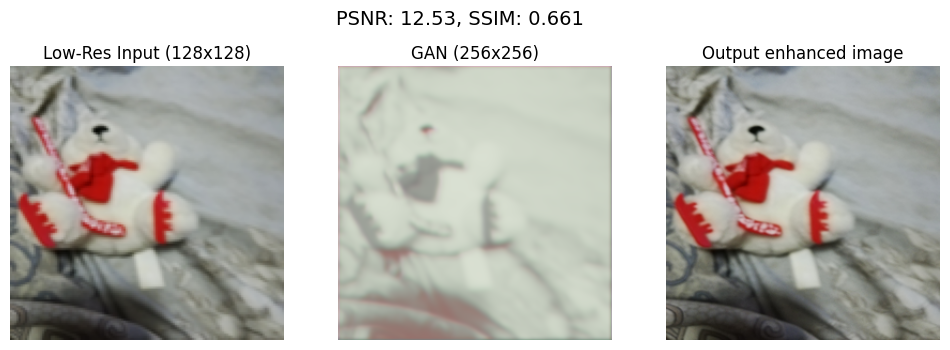

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# -- Load image and generate low-res version --
img_name = "/content/image/205_HUAWEI-P20-LITE_F.jpg"  # Replace with the path to your high-res image
try:
    hr_image = Image.open(img_name).convert('RGB').resize((256, 256))
except FileNotFoundError:
    print(f"Error: Image file '{img_name}' not found.")
    exit()

lr_image = hr_image.resize((128, 128), Image.BICUBIC)

# Convert to numpy arrays
hr_np = np.array(hr_image).astype(np.float32) / 255.
lr_np = np.array(lr_image).astype(np.float32) / 255.

# Convert to torch tensors
transform = ToTensor()
lr_tensor = transform(lr_image).unsqueeze(0)
hr_tensor = transform(hr_image).unsqueeze(0)

# -- Generator Network --
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1), nn.Tanh() # Tanh to output values between -1 and 1
        )

    def forward(self, x):
        return self.net(x)

# -- Discriminator Network --
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 3, stride=1, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)

# -- Setup --
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

lr_tensor = lr_tensor.to(device)
hr_tensor = hr_tensor.to(device)

# -- Training Loop --
epochs = 500
for epoch in range(epochs):
    # Train Discriminator
    optimizer_d.zero_grad()
    real_outputs = discriminator(hr_tensor)
    fake_outputs = discriminator(generator(lr_tensor))

    real_labels = torch.ones_like(real_outputs).to(device)
    fake_labels = torch.zeros_like(fake_outputs).to(device)

    d_loss_real = criterion(real_outputs, real_labels)
    d_loss_fake = criterion(fake_outputs, fake_labels)
    d_loss = d_loss_real + d_loss_fake

    d_loss.backward()
    optimizer_d.step()

    # Train Generator
    optimizer_g.zero_grad()
    fake_outputs = discriminator(generator(lr_tensor))
    g_loss = criterion(fake_outputs, real_labels) # generator tries to fool the discriminator

    g_loss.backward()
    optimizer_g.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# -- Evaluation --
with torch.no_grad():
    sr_image = generator(lr_tensor).squeeze().cpu().permute(1, 2, 0).clamp(-1, 1).numpy()
    sr_image = (sr_image +1)/2 # change range from -1,1 to 0,1

psnr_score = psnr(hr_np, sr_image)
ssim_score = ssim(hr_np, sr_image, channel_axis=2, data_range=1.0)

# -- Display --
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(lr_np)
plt.title("Low-Res Input (128x128)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sr_image)
plt.title("GAN (256x256)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(hr_np)
plt.title("Output enhanced image")
plt.axis("off")

plt.suptitle(f"PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.3f}", fontsize=14)
plt.show()